# Forecasting the Breeding Bird Survey

In [10]:
library(forecast)
library(dplyr)
library(broom)
library(MODISTools)

## Initial data setup

Load the BBS data and limit it to sites with contiguous time-series from 2000 to 2014 (the range spanned by the MODIS data).

In [2]:
data <- read.csv("./data/bbs_data.csv")
colnames(data)[3] <- "long"
contig_modern_routes <- read.csv('./data/contig_modern_routes.csv')
colnames(contig_modern_routes) <- c('site_id')
data_modern <- semi_join(data, contig_modern_routes)
data_modern <- filter(data_modern, year >= 2000)

#data <- data_modern
head(data)

Joining by: "site_id"


site_id      lat      long year species_id abundance
1    2001 34.86869 -87.60414 1967       2010         2
2    2001 34.86869 -87.60414 1967       2020         1
3    2001 34.86869 -87.60414 1967       2730         8
4    2001 34.86869 -87.60414 1967       3870        19
5    2001 34.86869 -87.60414 1967       4440         6
6    2001 34.86869 -87.60414 1967       5970         4

## Extract the long contiguous time-series

In [3]:
filtered_ts <- function(df){
    full_ts <- seq(from=min(df$year), to=max(df$year), by=1)
    contig_pos <- na.contiguous(match(full_ts,unique(df$year)))
    filter(df, year %in% full_ts[contig_pos])
    }

min_ts_length = 20

data_by_site <- group_by(data, site_id)
contig_ts <- do(data_by_site, filtered_ts(.))
contig_ts_by_site <- group_by(contig_ts, site_id)
contig_ts_length <- summarize(contig_ts_by_site, n_years = n_distinct(year))
long_ts <- filter(contig_ts_length, n_years >= min_ts_length)
contig_ts_long <- semi_join(contig_ts, long_ts)
head(contig_ts_long)

Joining by: "site_id"


Source: local data frame [6 x 6]
Groups: site_id

  site_id      lat      long year species_id abundance
1    2007 34.86804 -86.20304 1974       2010         1
2    2007 34.86804 -86.20304 1974       2730         4
3    2007 34.86804 -86.20304 1974       2890        24
4    2007 34.86804 -86.20304 1974       3131         2
5    2007 34.86804 -86.20304 1974       3160        48
6    2007 34.86804 -86.20304 1974       3250        10

In [4]:
data_by_site_yr <- group_by(contig_ts_long, site_id, year)
richness <- summarise(data_by_site_yr, richness = n_distinct(species_id))
head(richness)

Source: local data frame [6 x 3]
Groups: site_id

  site_id year richness
1    2007 1974       52
2    2007 1978       55
3    2007 1979       59
4    2007 1980       54
5    2007 1981       56
6    2007 1982       44

In [5]:
richness_by_site <- group_by(richness, site_id)
cat("There are", n_groups(richness_by_site), "continuous time-series with at least" , min_ts_length, "years of data")

There are 900 continuous time-series with at least 20 years of data

## NDVI time-series data

In [6]:
data_modern <- filter(data, year >= 2000)
data_by_site_modern <- group_by(data_modern, site_id)
contig_ts_modern <- do(data_by_site_modern, filtered_ts(.))
contig_ts_by_site_modern <- group_by(contig_ts_modern, site_id)
contig_ts_length_modern <- summarize(contig_ts_by_site_modern, n_years = n_distinct(year))
long_ts_modern <- filter(contig_ts_length_modern, n_years >= 15)
contig_ts_long_modern <- semi_join(contig_ts_modern, long_ts_modern)

data_by_site_yr_ndvi <- group_by(contig_ts_long_modern, site_id, lat, long, year)
richness_ndvi <- summarise(data_by_site_yr_ndvi, richness = n_distinct(species_id))
richness_ndvi$start.date <- paste(richness_ndvi$year, "-06-01", sep = "")
richness_ndvi$end.date <- paste(richness_ndvi$year, "-06-30", sep = "")
head(richness_ndvi)

Joining by: "site_id"


Source: local data frame [6 x 7]
Groups: site_id, lat, long

  site_id      lat      long year richness start.date   end.date
1    2001 34.86869 -87.60414 2000       61 2000-06-01 2000-06-30
2    2001 34.86869 -87.60414 2001       58 2001-06-01 2001-06-30
3    2001 34.86869 -87.60414 2002       61 2002-06-01 2002-06-30
4    2001 34.86869 -87.60414 2003       66 2003-06-01 2003-06-30
5    2001 34.86869 -87.60414 2004       62 2004-06-01 2004-06-30
6    2001 34.86869 -87.60414 2005       59 2005-06-01 2005-06-30

## Forecasting

Generate forecasts for naive, average, and ARIMA time-series models for each site.

In [18]:
lag <- 5
out <- do(richness_by_site,
          cast_naive = naive(.$richness[1:(length(.$richness) - lag - 1)], lag)$mean,
          cast_avg = meanf(.$richness[1:(length(.$richness) - lag - 1)], lag)$mean,
          cast_arima = forecast(auto.arima(.$richness[1:(length(.$richness) - lag - 1)], seasonal = FALSE), h = lag)$mean,
          test_set = (.$richness[(length(.$richness) - lag):length(.$richness)])
         )
head(out)

Source: local data frame [6 x 5]

  site_id cast_naive cast_avg cast_arima test_set
1    2007    <S3:ts> <dbl[5]>    <S3:ts> <int[6]>
2    2013    <S3:ts> <dbl[5]>    <S3:ts> <int[6]>
3    2014    <S3:ts> <dbl[5]>    <S3:ts> <int[6]>
4    2015    <S3:ts> <dbl[5]>    <S3:ts> <int[6]>
5    2017    <S3:ts> <dbl[5]>    <S3:ts> <int[6]>
6    2019    <S3:ts> <dbl[5]>    <S3:ts> <int[6]>

## Forecasting experiments

In [149]:
examp <- filter(richness, site_id == 2007)
forecast <- naive(examp$richness)
examp$richness[1:length(examp$richness)]

[1] 52 55 59 54 56 44 51 43 48 45 46 49 46 49 47 50 44 41 46 49 43 48 46 45

In [153]:
lag <- 5
out <- do(richness_by_site,
          cast_naive = naive(.$richness[1:(length(.$richness) - lag - 1)], lag)$mean,
          cast_avg = meanf(.$richness[1:(length(.$richness) - lag - 1)], lag)$mean,
          cast_arima = forecast(auto.arima(.$richness[1:(length(.$richness) - lag - 1)], seasonal = FALSE), h = lag)$mean
         )
head(out)

Source: local data frame [6 x 4]

  site_id cast_naive cast_avg    cast_arima
1    2007    <S3:ts> <dbl[5]> <S3:forecast>
2    2013    <S3:ts> <dbl[5]> <S3:forecast>
3    2014    <S3:ts> <dbl[5]> <S3:forecast>
4    2015    <S3:ts> <dbl[5]> <S3:forecast>
5    2017    <S3:ts> <dbl[5]> <S3:forecast>
6    2019    <S3:ts> <dbl[5]> <S3:forecast>

In [14]:
out$cast[[1]]

Time Series:
Start = 11 
End = 15 
Frequency = 1 
[1] 58 58 58 58 58

In [150]:
train_set <- 1:(length(examp$richness)-lag - 1)
test_set <- (length(examp$richness)-lag):length(examp$richness)
model <- auto.arima(examp$richness[train_set], seasonal = FALSE)
cast_arima <- forecast(model, h = 5)
cast_naive <- naive(examp$richness[train_set], h = 5)
cast_avg <- meanf(examp$richness[train_set], h = 5)
examp$richness[test_set] - cast_arima$mean
examp$richness[test_set] - cast_naive$mean
examp$richness[test_set] - cast_avg$mean
model

Time Series:
Start = 20 
End = 24 
Frequency = 1 
[1]  6.156072 -1.836086  4.421392  1.627654  1.128673

Time Series:
Start = 20 
End = 24 
Frequency = 1 
[1]  3 -3  2  0 -1

[1]  0.3157895 -5.6842105 -0.6842105 -2.6842105 -3.6842105

Series: examp$richness[train_set] 
ARIMA(1,1,0)                    

Coefficients:
          ar1
      -0.6312
s.e.   0.1767

sigma^2 estimated as 14.9:  log likelihood=-50.11
AIC=104.21   AICc=105.01   BIC=105.99

## NDVI based forecasting

In [7]:
## NDVI
output <- capture.output(
                         MODISSummaries(LoadDat = richness_ndvi, Dir = "./data/modisdata/",
                                        Product = "MOD13Q1", Bands = c("250m_16_days_NDVI"),
                                        ValidRange = c(-2000,10000),
                                        NoDataFill = -3000, ScaleFactor = 0.0001, StartDate = TRUE)
)

Warning message:
In min(as.numeric(band.time.series[, i]) * ScaleFactor, na.rm = TRUE): no non-missing arguments to min; returning InfWarning message:
In max(as.numeric(band.time.series[, i]) * ScaleFactor, na.rm = TRUE): no non-missing arguments to max; returning -InfWarning message:
In min(as.numeric(band.time.series[, i]) * ScaleFactor, na.rm = TRUE): no non-missing arguments to min; returning InfWarning message:
In max(as.numeric(band.time.series[, i]) * ScaleFactor, na.rm = TRUE): no non-missing arguments to max; returning -InfWarning message:
In min(as.numeric(band.time.series[, i]) * ScaleFactor, na.rm = TRUE): no non-missing arguments to min; returning InfWarning message:
In max(as.numeric(band.time.series[, i]) * ScaleFactor, na.rm = TRUE): no non-missing arguments to max; returning -InfWarning message:
In min(as.numeric(band.time.series[, i]) * ScaleFactor, na.rm = TRUE): no non-missing arguments to min; returning InfWarning message:
In max(as.numeric(band.time.series[, i]) *

site_id      lat      long year richness start.date   end.date
1    2001 34.86869 -87.60414 2000       61 2000-06-01 2000-06-30
2    2001 34.86869 -87.60414 2001       58 2001-06-01 2001-06-30
3    2001 34.86869 -87.60414 2002       61 2002-06-01 2002-06-30
4    2001 34.86869 -87.60414 2003       66 2003-06-01 2003-06-30
5    2001 34.86869 -87.60414 2004       62 2004-06-01 2004-06-30
6    2001 34.86869 -87.60414 2005       59 2005-06-01 2005-06-30
                                             SubsetID    ndvi
1 Lat34.86869Lon-87.60414Start2000-06-01End2000-06-30 0.74035
2 Lat34.86869Lon-87.60414Start2001-06-01End2001-06-30 0.76325
3 Lat34.86869Lon-87.60414Start2002-06-01End2002-06-30 0.77125
4 Lat34.86869Lon-87.60414Start2003-06-01End2003-06-30 0.74540
5 Lat34.86869Lon-87.60414Start2004-06-01End2004-06-30 0.80200
6 Lat34.86869Lon-87.60414Start2005-06-01End2005-06-30 0.77445

site_id      lat      long year richness start.date   end.date
1      3008 63.61521 -143.9863 2000       20 2000-06-01 2000-06-30
2      3008 63.61521 -143.9863 2001       23 2001-06-01 2001-06-30
3      3008 63.61521 -143.9863 2002       21 2002-06-01 2002-06-30
4      3008 63.61521 -143.9863 2003       25 2003-06-01 2003-06-30
5      3008 63.61521 -143.9863 2004       27 2004-06-01 2004-06-30
6      3008 63.61521 -143.9863 2005       24 2005-06-01 2005-06-30
7      3008 63.61521 -143.9863 2006       22 2006-06-01 2006-06-30
8      3008 63.61521 -143.9863 2007       24 2007-06-01 2007-06-30
9      3008 63.61521 -143.9863 2008       22 2008-06-01 2008-06-30
10     3008 63.61521 -143.9863 2009       23 2009-06-01 2009-06-30
11     3008 63.61521 -143.9863 2010       24 2010-06-01 2010-06-30
12     3008 63.61521 -143.9863 2011       25 2011-06-01 2011-06-30
13     3008 63.61521 -143.9863 2012       24 2012-06-01 2012-06-30
14     3008 63.61521 -143.9863 2013       21 2013-06-01 2013-06-30
15     3008 63.61521 -143.9863 2014       29 2014-06-01 2014-06-30
16     3010 63.01273 -141.8053 2000       34 2000-06-01 2000-06-30
17     3010 63.01273 -141.8053 2001       39 2001-06-01 2001-06-30
18     3010 63.01273 -141.8053 2002       33 2002-06-01 2002-06-30
19     3010 63.01273 -141.8053 2003       37 2003-06-01 2003-06-30
20     3010 63.01273 -141.8053 2004       30 2004-06-01 2004-06-30
21     3010 63.01273 -141.8053 2005       32 2005-06-01 2005-06-30
22     3010 63.01273 -141.8053 2006       34 2006-06-01 2006-06-30
23     3010 63.01273 -141.8053 2007       32 2007-06-01 2007-06-30
24     3010 63.01273 -141.8053 2008       34 2008-06-01 2008-06-30
25     3010 63.01273 -141.8053 2009       30 2009-06-01 2009-06-30
26     3010 63.01273 -141.8053 2010       31 2010-06-01 2010-06-30
27     3010 63.01273 -141.8053 2011       31 2011-06-01 2011-06-30
28     3010 63.01273 -141.8053 2012       29 2012-06-01 2012-06-30
29     3010 63.01273 -141.8053 2013       32 2013-06-01 2013-06-30
30     3010 63.01273 -141.8053 2014       33 2014-06-01 2014-06-30
31     3011 63.05319 -146.0607 2000       27 2000-06-01 2000-06-30
32     3011 63.05319 -146.0607 2001       34 2001-06-01 2001-06-30
33     3011 63.05319 -146.0607 2002       27 2002-06-01 2002-06-30
34     3011 63.05319 -146.0607 2003       34 2003-06-01 2003-06-30
35     3011 63.05319 -146.0607 2004       35 2004-06-01 2004-06-30
36     3011 63.05319 -146.0607 2005       36 2005-06-01 2005-06-30
37     3011 63.05319 -146.0607 2006       37 2006-06-01 2006-06-30
38     3011 63.05319 -146.0607 2007       40 2007-06-01 2007-06-30
39     3011 63.05319 -146.0607 2008       30 2008-06-01 2008-06-30
40     3011 63.05319 -146.0607 2009       24 2009-06-01 2009-06-30
41     3011 63.05319 -146.0607 2010       25 2010-06-01 2010-06-30
42     3011 63.05319 -146.0607 2011       40 2011-06-01 2011-06-30
43     3011 63.05319 -146.0607 2012       35 2012-06-01 2012-06-30
44     3011 63.05319 -146.0607 2013       29 2013-06-01 2013-06-30
45     3011 63.05319 -146.0607 2014       24 2014-06-01 2014-06-30
46     3041 64.54641 -146.9949 2000       28 2000-06-01 2000-06-30
47     3041 64.54641 -146.9949 2001       27 2001-06-01 2001-06-30
48     3041 64.54641 -146.9949 2002       22 2002-06-01 2002-06-30
49     3041 64.54641 -146.9949 2003       23 2003-06-01 2003-06-30
50     3041 64.54641 -146.9949 2004       23 2004-06-01 2004-06-30
51     3041 64.54641 -146.9949 2005       24 2005-06-01 2005-06-30
52     3041 64.54641 -146.9949 2006       24 2006-06-01 2006-06-30
53     3041 64.54641 -146.9949 2007       26 2007-06-01 2007-06-30
54     3041 64.54641 -146.9949 2008       23 2008-06-01 2008-06-30
55     3041 64.54641 -146.9949 2009       21 2009-06-01 2009-06-30
56     3041 64.54641 -146.9949 2010       24 2010-06-01 2010-06-30
57     3041 64.54641 -146.9949 2011       18 2011-06-01 2011-06-30
58     3041 64.54641 -146.9949 2012       23 2012-06-01 2012-06-30
59     3041 64.54641 -146.9949 2013       19 2013-0

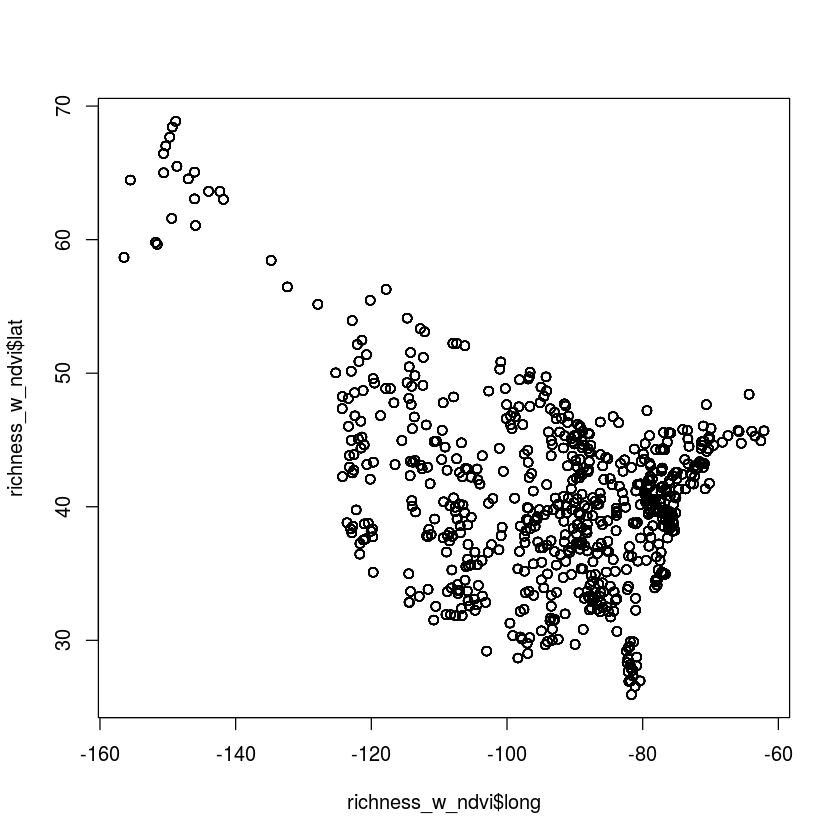

In [37]:
# MODISSummaries outputs a time stamped file starting w/MODIS_Data
# Get the most recent version of this file
modis_data_files <- list.files("./data/modisdata/", pattern = "MODIS_Data", full.names = TRUE)
richness_w_ndvi <- read.csv(modis_data_files[1])
colnames(richness_w_ndvi)[9] <- "ndvi"
head(richness_w_ndvi)
plot(richness_w_ndvi$long, richness_w_ndvi$lat)
filter(richness_w_ndvi, lat > 60)

Source: local data frame [6 x 3]

  site_id meanrich  meanndvi
1    2001 62.73333 0.7401100
2    2021 45.53333 0.7774467
3    2024 63.73333 0.6767700
4    2025 65.06667 0.6467767
5    2029 66.40000 0.6983000
6    2043 43.40000 0.7208067


Call:
lm(formula = meanrich ~ meanndvi, data = richness_w_ndvi_site_avg)

Residuals:
    Min      1Q  Median      3Q     Max 
-40.039  -6.783   0.545   7.106  43.106 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   31.018      1.729   17.94   <2e-16 ***
meanndvi      38.847      2.554   15.21   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 11.59 on 648 degrees of freedom
  (7 observations deleted due to missingness)
Multiple R-squared:  0.263,	Adjusted R-squared:  0.2619 
F-statistic: 231.3 on 1 and 648 DF,  p-value: < 2.2e-16


ERROR: Error in eval(expr, envir, enclos): object 'lat' not found


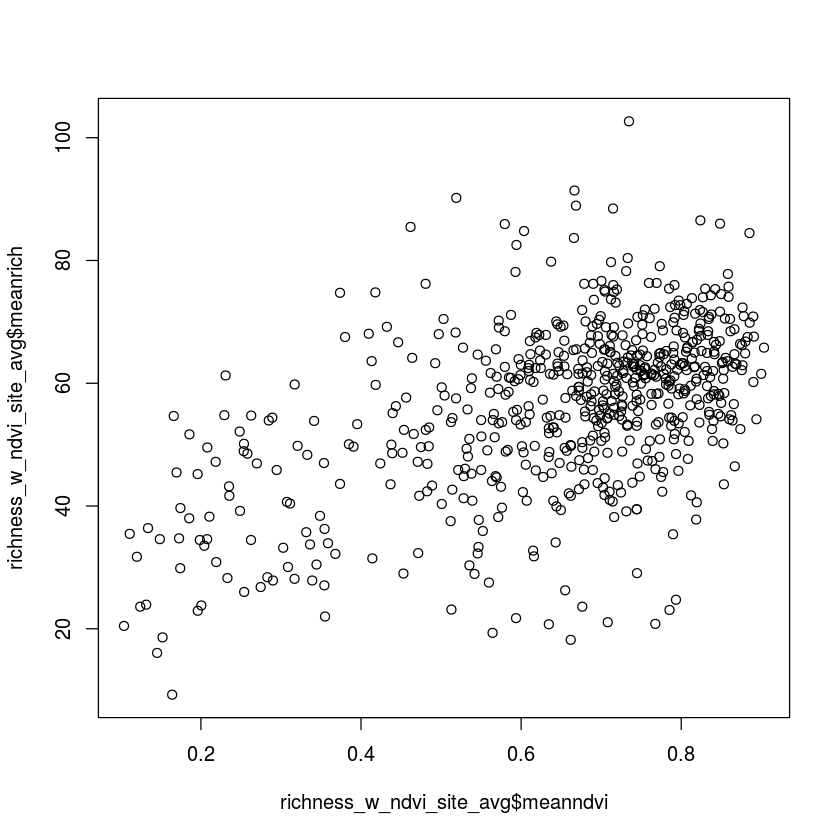

In [35]:
richness_w_ndvi_by_site <- group_by(richness_w_ndvi, site_id)
richness_w_ndvi_site_avg <- summarize(richness_w_ndvi_by_site, meanrich = mean(richness), meanndvi = mean(ndvi))
head(richness_w_ndvi_site_avg)
summary(lm(meanrich ~ meanndvi, data = richness_w_ndvi_site_avg))
plot(richness_w_ndvi_site_avg$meanndvi, richness_w_ndvi_site_avg$meanrich)

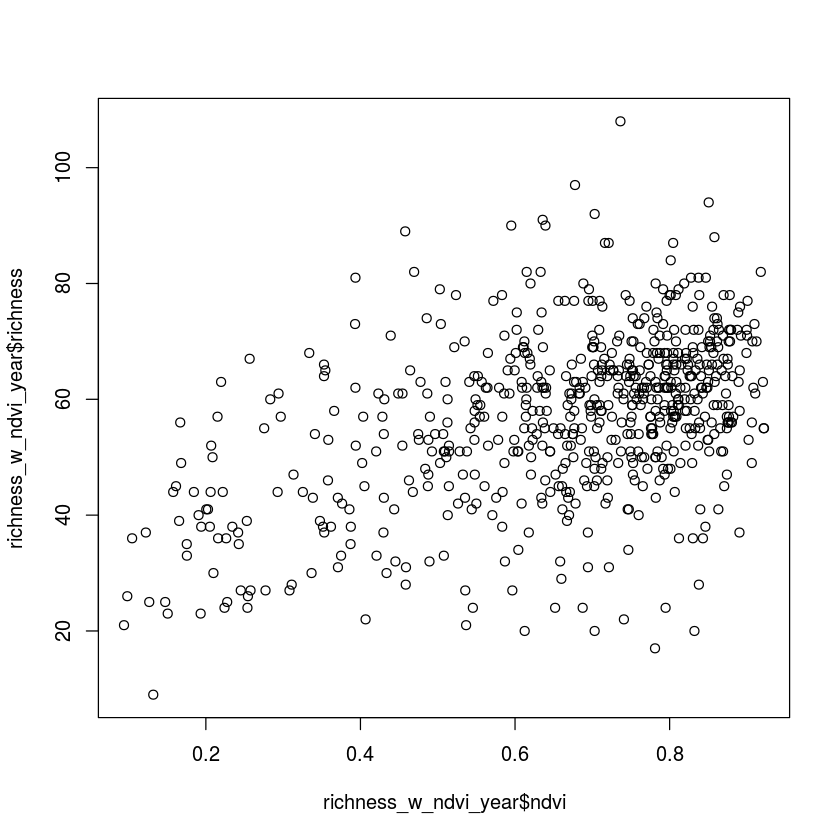

In [62]:
richness_w_ndvi_year <- filter(richness_w_ndvi, year == 2000)
plot(richness_w_ndvi_year$ndvi, richness_w_ndvi_year$richness)

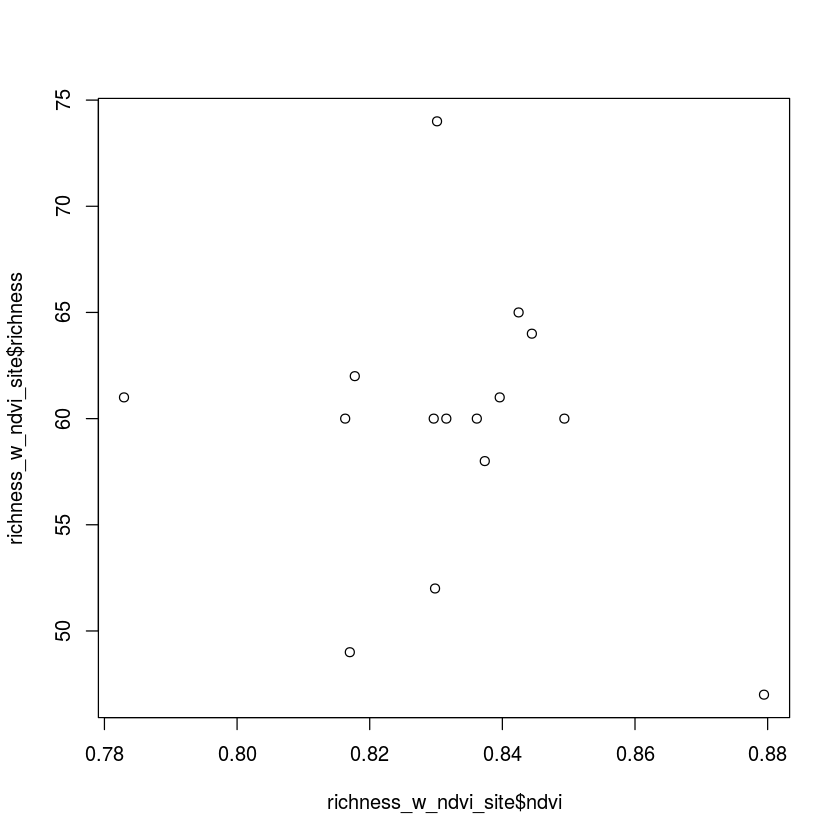

In [41]:
richness_w_ndvi_site <- filter(richness_w_ndvi, site_id == unique(richness_w_ndvi$site_id)[200])
plot(richness_w_ndvi_site$ndvi, richness_w_ndvi_site$richness)

In [90]:
#richness_w_ndvi_by_year <- group_by(richness_w_ndvi, year)
years <- 2000:2014
results <- data.frame(year = numeric(), slope = numeric(), intercept = numeric(), r2 = numeric())
for (focalyear in years){
    subdata <- filter(richness_w_ndvi, year == focalyear)
    fit <- lm(richness ~ ndvi, data = subdata)
    results <- rbind(results, data.frame(year, fit$coefficients[2], fit$coefficients[1]))
}


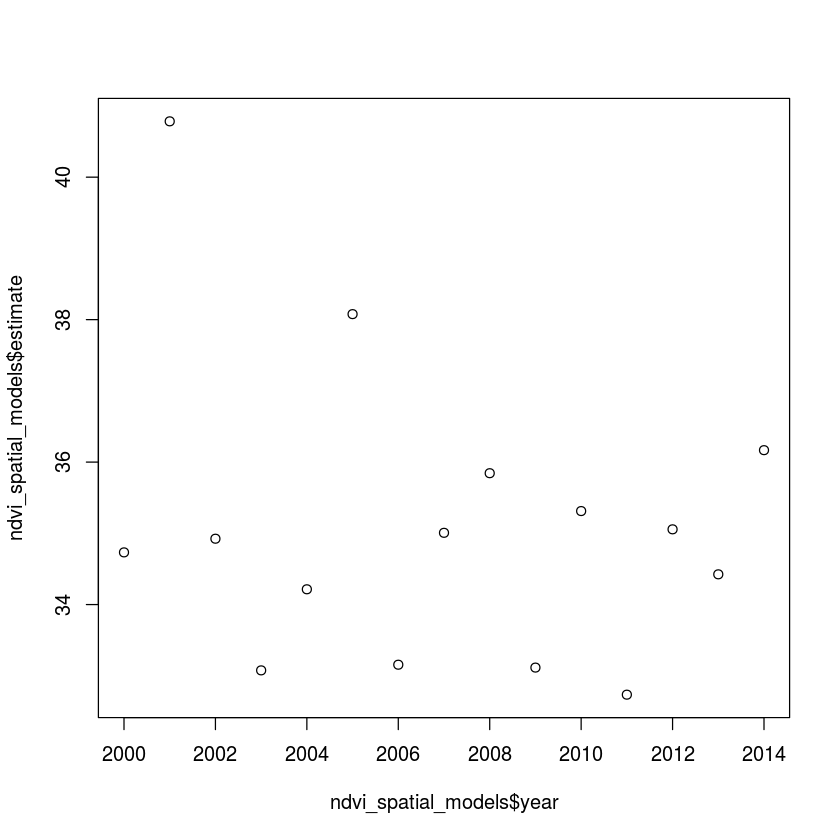

In [20]:
richness_w_ndvi_by_year <- group_by(richness_w_ndvi, year)
results <- richness_w_ndvi_by_year %>%
           do(fitndvi = lm(richness ~ ndvi, data = .))
ndvi_spatial_models <- filter(tidy(results, fitndvi), term == 'ndvi')
plot(ndvi_spatial_models$year, ndvi_spatial_models$estimate)